In [14]:


import matplotlib.pyplot as plt
import numpy as np
	
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [15]:
from utils import decorate, savefig
!mkdir -p figs

In [16]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist  

In [17]:
def locs_where(condition):
    return list(zip(*np.nonzero(condition)))

In [18]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
	
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)  

In [19]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array
	
class Schelling(Cell2D):



    options = dict(mode='same', boundary='wrap')



    kernel = np.array([[1,1,1],

                       [1,0,1],

                       [1,1,1]], dtype=np.int8)



    def __init__(self, n, p):

        self.p = p



        choices = np.array([0,1,2], dtype=np.int8)

        probs = [0.1, 0.45, 0.45]

        self.array = np.random.choice(choices, (n,n), p=probs)



    def count_neighbors(self):



        a = self.array



        empty = a==0

        red = a==1

        blue = a==2



        num_red = correlate2d(red, self.kernel, **self.options)

        num_blue = correlate2d(blue, self.kernel, **self.options)

        num_neighbors = num_red + num_blue



        frac_red = num_red / num_neighbors

        frac_blue = num_blue / num_neighbors



        frac_same = np.where(red, frac_red, frac_blue)



        frac_same[empty] = np.nan



        return empty, frac_red, frac_blue, frac_same



    def segregation(self):

        _, _, _, frac_same = self.count_neighbors()

        return np.nanmean(frac_same)



    def step(self):



        a = self.array

        empty, _, _, frac_same = self.count_neighbors()



        with np.errstate(invalid='ignore'):

            unhappy = frac_same < self.p

        unhappy_locs = locs_where(unhappy)

        empty_locs = locs_where(empty)



        if len(unhappy_locs):

            np.random.shuffle(unhappy_locs)



        num_empty = np.sum(empty)



        for source in unhappy_locs:

            i = np.random.randint(num_empty)

            dest = empty_locs[i]



            a[dest] = a[source]

            a[source] = 0

            empty_locs[i] = source



            num_empty2 = np.sum(a==0)

            assert num_empty == num_empty2



        return np.nanmean(frac_same)



    def draw(self):

        return draw_array(self.array, cmap=cmap, vmax=2)

In [20]:
    def count_neighbors(self):
        a = self.array
			
        empty = a==0
        red = a==1
        blue = a==2
			
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue
			
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
			
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
			
        frac_same = np.where(red, frac_red, frac_blue)
        frac_same[empty] = np.nan
			
        return empty, frac_red, frac_blue, frac_same

In [21]:
    def segregation(self):
        _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)

In [22]:
    def step(self):
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
			
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
            unhappy_locs = locs_where(unhappy)          
            empty_locs = locs_where(empty)
				
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
				
        num_empty = np.sum(empty)
			
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
				
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
                
            num_empty2 = np.sum(a==0)
            assert num_empty == num_empty2
				
        return np.nanmean(frac_same)

In [23]:
    def draw(self):
        return draw_array(self.array, cmap=cmap, vmax=2)    

0.5302818828680897

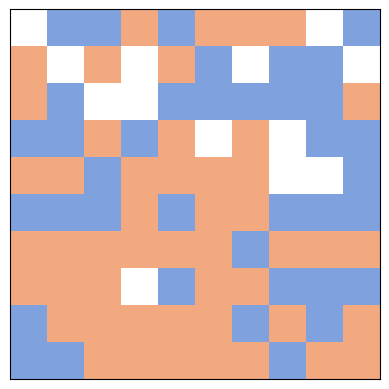

In [24]:
grid = Schelling(n=10, p=0.3)
grid.draw()
grid.segregation()

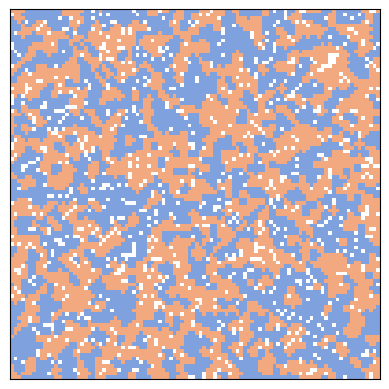

In [25]:
grid = Schelling(n=100, p=0.3)
grid.animate(frames=30, interval=0.1) 

Saving figure to file figs/chap09-1


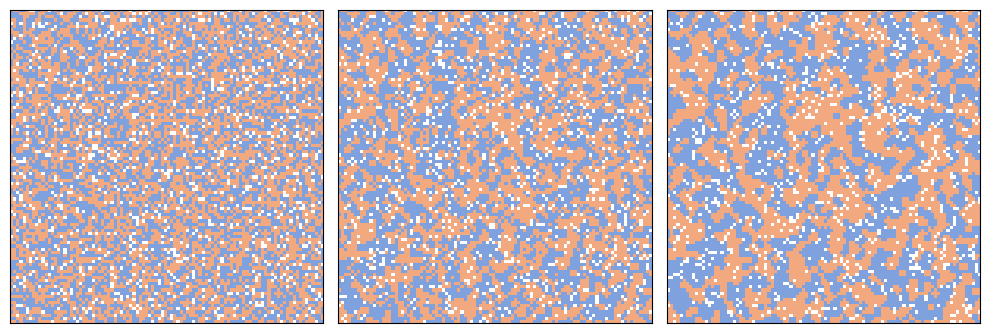

In [26]:
from utils import three_frame
	
grid = Schelling(n=100, p=0.3)
three_frame(grid, [0, 2, 8])
	
savefig('figs/chap09-1')    

0.5 0.8707797990077598 0.3707797990077598
0.4 0.8181252110773387 0.4181252110773387
0.3 0.7538847395404771 0.4538847395404771
0.2 0.5729593164353953 0.3729593164353953
Saving figure to file figs/chap09-2


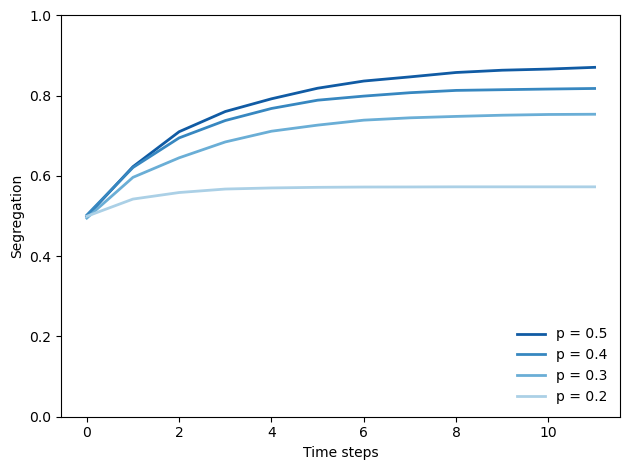

In [27]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)
	
np.random.seed(17)
for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
	
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])
	
savefig('figs/chap09-2')    